# Feature Impute
Objective: Impute missing data for all features except permeability.  
We need complete features for PCA and model for permeability. This page on multiple imputation is helpful. https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py  

Rock facies has 8.9\% missing values, and is categorical which takes an extra step to impute. Can we drop rows with missing rock facies?

In [1]:
# Import all the good stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf

import os
import pandas as pd
import tensorflow as tf
import subprocess
import pickle
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [2]:
# Read producer
prod = pd.read_csv("https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/wellbore_data_producer_wells.csv?token=AN5MCLBHM2IYJT6OO42JN43AQDE4U")
# Read cumulative oil
cumoil = pd.read_csv('https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/production_history.csv?token=AN5MCLGECACCOYCJDAQCPYTAQDFCE')

In [3]:
# Join on Well_ID (Left outer join)
df = pd.merge(prod, cumoil, on='Well_ID',how='left')
df.head()


,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Cumulative oil production (1 yr), MSTB","Cumulative oil production (2 yr), MSTB","Cumulative oil production (3 yr), MSTB","Cumulative Water production (1 yr), MSTB","Cumulative Water production (2 yr), MSTB","Cumulative Water production (3 yr), MSTB"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,450.98,684.2,847.33,494.89,1236.4,2108.7
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,450.98,684.2,847.33,494.89,1236.4,2108.7
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN,450.98,684.2,847.33,494.89,1236.4,2108.7
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,450.98,684.2,847.33,494.89,1236.4,2108.7
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834,450.98,684.2,847.33,494.89,1236.4,2108.7


In [4]:
# Select the relevant attributes (columns) to impute
X = df.iloc[:,4:13].copy()
X.drop(['Rock facies'],axis=1,inplace=True)
X_coln = X.columns
X.head()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.13330,NaN,6981171.853,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.13865,NaN,7234748.871,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.14638,NaN,7157383.755,1.991045,3462.569030,28.232152,1636.279139,NaN
3,NaN,NaN,NaN,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.14993,NaN,NaN,1.664371,3919.585777,NaN,1636.846284,5.277834


<AxesSubplot:>

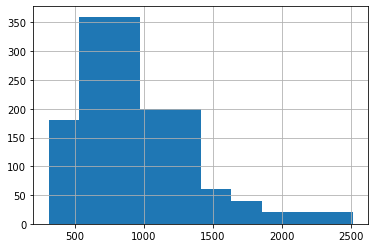

In [5]:
# Select label, the 3-year cumulative oil prod
y = df.loc[:,'Cumulative oil production (3 yr), MSTB'].copy()
y_name = y.name
y.hist()

<AxesSubplot:>

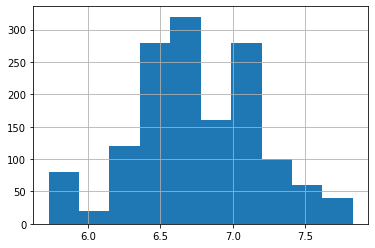

In [6]:
# should be log transformed
y_log = np.log(y)
y_log.hist()

In [7]:
# Standardize
std_scaler_X = StandardScaler()
std_scaler_y = StandardScaler()
X_std = std_scaler_X.fit_transform(X)
y_std = std_scaler_y.fit_transform(np.array(y).reshape(-1,1))

In [11]:
# Check the features
X.head()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.13330,NaN,6981171.853,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.13865,NaN,7234748.871,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.14638,NaN,7157383.755,1.991045,3462.569030,28.232152,1636.279139,NaN
3,NaN,NaN,NaN,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.14993,NaN,NaN,1.664371,3919.585777,NaN,1636.846284,5.277834


In [12]:
# Estimate score after simple imputation (mean and median strategies)
N_SPLITS = 5
br_estimator = BayesianRidge()
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_std, y_std, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )
# Bayesian ridge scores
score_simple_imputer

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

,mean,median
0,-0.517795,-0.517711
1,-0.708358,-0.708734
2,-1.136502,-1.140633
3,-1.182870,-1.187778
4,-1.156771,-1.156434


In [13]:
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_std, y_std, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=10)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_std, y_std, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\linear_model\_bayes.py", line 193, in fit
    X, y = self._validate_data(X, y, dtype=np.float64, y_numeric=True)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [14]:
scores

Original SimpleImputer           IterativeImputer                        \
  Full Data          mean    median    BayesianRidge DecisionTreeRegressor   
0       NaN     -0.517795 -0.517711        -0.520261             -0.507757   
1       NaN     -0.708358 -0.708734        -0.699667             -0.664689   
2       NaN     -1.136502 -1.140633        -1.137082             -1.161763   
3       NaN     -1.182870 -1.187778        -1.168008             -1.134559   
4       NaN     -1.156771 -1.156434        -1.155768             -1.141107   

                                           
  ExtraTreesRegressor KNeighborsRegressor  
0           -0.507261           -0.500639  
1           -0.641382           -0.685722  
2           -1.052141           -1.098359  
3           -1.068393           -1.128125  
4           -1.098190           -1.121999

In [15]:
# Now use KNeighbors in IterativeImputer
# Define a list of estimators
estimators = [
    KNeighborsRegressor(n_neighbors=i) for i in range(1,20)
]

# Get scores form each imputation method
score_iterative_imputer=pd.DataFrame().copy()
for impute_estimator,i in zip(estimators,range(len(estimators))):
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer['n={}'.format(i+1)] = \
        cross_val_score(
            estimator, X_std, y_std, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

In [16]:
# 7 neighbours best score
score_iterative_imputer.sum(axis=0)

n=1    -4.666504
n=2    -4.561656
n=3    -4.549469
n=4    -4.538292
n=5    -4.533010
n=6    -4.545989
n=7    -4.515473
n=8    -4.514759
n=9    -4.534978
n=10   -4.534845
n=11   -4.531843
n=12   -4.538211
n=13   -4.538971
n=14   -4.545852
n=15   -4.552070
n=16   -4.552803
n=17   -4.550749
n=18   -4.542214
n=19   -4.543244
dtype: float64

In [17]:
# Check if iterative imputer works
imp = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=7))
X_full_std =imp.fit_transform(X_std,y_std)
# Inverse standardize to get actual values
X_full = std_scaler_X.inverse_transform(X_full_std)
# Restore column names
X_full = pd.DataFrame(X_full, columns=X_coln)
# Display
X_full.head()

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.133300,119.381002,6.981172e+06,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.138650,102.107204,7.234749e+06,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.146380,92.960363,7.157384e+06,1.991045,3462.569030,28.232152,1636.279139,6.541232
3,0.138536,113.987555,7.214059e+06,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.149930,121.222477,7.186176e+06,1.664371,3919.585777,30.230167,1636.846284,5.277834


In [18]:
# Sanity check on X_full: No impossible values (Ex: Negatives). Verify all missing values filled.
X_full.describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.128157,109.281118,7.322827e+06,2.041999,3698.273239,27.310685,1674.932994,5.752602
std,0.035402,60.721637,3.058341e+05,0.412053,720.181902,5.422844,95.599547,1.488458
min,0.040270,2.214604,6.559277e+06,1.421943,1661.828496,13.205134,1307.887097,1.650985
25%,0.116936,62.673339,7.112124e+06,1.727686,3182.253832,23.424223,1613.457483,4.769711
50%,0.137895,103.137041,7.269821e+06,1.977340,3669.874530,26.753884,1673.164285,5.599665
75%,0.151987,139.479480,7.485948e+06,2.210757,4212.361841,30.906669,1736.568303,6.550504
max,0.188910,489.219402,8.249272e+06,3.530373,6179.653016,48.123292,1989.829247,11.820038


In [19]:
# Compare to original features
X_full.describe()-X.describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,192.000000,1.176000e+03,103.000000,212.000000,184.000000,1.990000e+02,190.000000,1.750000e+02
mean,0.000411,-2.901621e+00,-2959.294233,-0.010522,9.615386,2.180784e-02,-1.225081,-3.765285e-05
std,-0.000617,-2.017280e+01,-4278.465827,-0.005570,-7.034336,-1.764407e-03,-5.030547,-3.024107e-02
min,0.000000,4.440892e-16,0.000000,0.000000,0.000000,-1.776357e-15,0.000000,4.440892e-16
25%,0.002983,1.113236e+01,1067.655000,-0.006367,3.864346,-4.231534e-02,4.529174,1.223652e-02
50%,0.000400,9.156319e+00,-4512.196500,-0.011201,5.677704,1.064187e-01,-1.672289,-1.060188e-02
75%,-0.000337,-1.510541e+01,-17429.839750,-0.018750,-2.563124,3.203982e-02,-9.512948,-4.999953e-02
max,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00


In [20]:
# Compare before and after impute
# Confirm that std and meand don't change too much
pd.DataFrame(X_full_std, columns=X.columns).describe()-pd.DataFrame(X_std, columns=X.columns).describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,192.000000,1176.000000,103.000000,212.000000,184.000000,199.000000,190.000000,175.000000
mean,0.011426,-0.035933,-0.009546,-0.025204,0.013227,0.004022,-0.012179,-0.000025
std,-0.017146,-0.249812,-0.013802,-0.013342,-0.009677,-0.000325,-0.050010,-0.019920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082854,0.137859,0.003444,-0.015251,0.005316,-0.007804,0.045026,0.008060
50%,0.011109,0.113388,-0.014556,-0.026833,0.007811,0.019626,-0.016625,-0.006984
75%,-0.009374,-0.187060,-0.056226,-0.044915,-0.003526,0.005909,-0.094571,-0.032935
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Reduce dimensionality by PCA
explained_variance=[]
print('Explained Variance by Dimension:')
for i in range(1,9):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_full_std)
    explained_variance.append(pca.explained_variance_ratio_.sum())
    print(i, pca.explained_variance_ratio_.sum())

Explained Variance by Dimension:
1 0.44428908005047263
2 0.7698222518782095
3 0.8929287770208275
4 0.937039636743103
5 0.9596593619509111
6 0.9785625299661638
7 0.992246744028142
8 0.9999999999999999


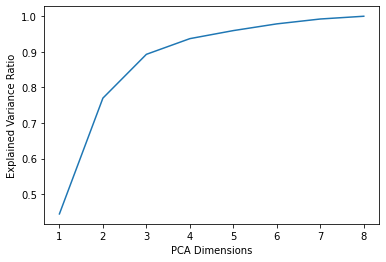

In [22]:
# Plot explained variance ratio vs number of dimensions kept
# Looks like 4 dims is appropriate. 5 dims is too high given our data set.
plt.plot(range(1,9),explained_variance)
plt.xticks(np.arange(1, 9))
plt.xlabel('PCA Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.savefig('pca_expl_var.png')

In [23]:
# Reduce to 4 dims
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_full_std)
pd.DataFrame(X_pca).describe()

,0,1,2,3
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,-4.623395e-17,-1.946692e-17,-1.946692e-17,-1.216683e-18
std,1.804126e+00,1.544300e+00,9.496740e-01,5.684690e-01
min,-3.786430e+00,-4.059509e+00,-3.118426e+00,-2.061907e+00
25%,-1.342848e+00,-1.015650e+00,-6.245097e-01,-3.864520e-01
50%,-1.560896e-01,-2.310335e-01,1.695664e-02,1.999600e-02
75%,9.568880e-01,8.104718e-01,6.112811e-01,3.792436e-01
max,6.200217e+00,4.872814e+00,3.584160e+00,2.364221e+00


In [24]:
# Min-max normalize the X_pca
x_min_max_scaler = MinMaxScaler()
X_pca_minmax = x_min_max_scaler.fit_transform(X_pca)
pd.DataFrame(X_pca_minmax).describe()

,0,1,2,3
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.379149,0.454474,0.465257,0.465849
std,0.180654,0.172889,0.141688,0.128435
min,0.000000,0.000000,0.000000,0.000000
25%,0.244685,0.340769,0.372083,0.378537
50%,0.363519,0.428609,0.467787,0.470367
75%,0.474966,0.545209,0.556458,0.551532
max,1.000000,1.000000,1.000000,1.000000


In [25]:
# Min-max normalize the y
y_min_max_scaler = MinMaxScaler()
y_min_max = y_min_max_scaler.fit_transform(np.array(y).reshape(-1,1))
pd.DataFrame(y_min_max).describe()

,0
count,1460.000000
mean,0.287153
std,0.193358
min,0.000000
25%,0.152226
50%,0.232117
75%,0.397883
max,1.000000


array([[<AxesSubplot:title={'center':'Cumulative oil production (3 yr), MSTB'}>]],
      dtype=object)

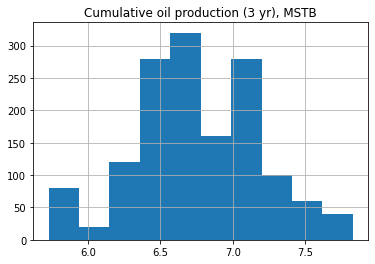

In [26]:
pd.DataFrame(np.log(y)).hist()

In [ ]:
# Create ANN model for oil recov
def model_construct(n_layers, n_nodes, n_inputs):
    '''
    n_layers
    n_nodes
    n_inputs: Dims of inputs, X_train_prepared.shape[1]
    '''
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=[n_inputs]))
    for _ in range(n_layers-1):
        model.add(tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(tf.keras.layers.Dense(1))

    # Remove lr if scheduler in use?
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
                  metrics=['mse', 'mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [ ]:
# Store version info as file in directory
def get_git_revision_hash():
    return subprocess.check_output(['git', 'rev-parse', 'HEAD'])

In [ ]:
# Function to train ANN model
def train_model(model,
                X,
                y,
                batch_size,
                n_layers,
                n_nodes,
                epochs,
                initial_epoch,
                log_save_dir,
                name_prefix):
    # Create Directory for Logs
    model_name = name_prefix+'_'+str(batch_size)+'_'+str(n_layers)+'_'+str(n_nodes)+'_'+str(epochs)+'_'
    logdir = log_save_dir + ".\\logs\\scalars\\" + model_name + str(
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    logdir = logdir
    if not os.path.exists(logdir):
        os.makedirs(logdir)
        print('New logdir created.')
        
    # Logs
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=0,  # How often to log histogram visualizations
        write_graph=True,
        update_freq='epoch',
        profile_batch=0,  # set to 0. Else bug Tensorboard not show train loss.
        embeddings_freq=0,  # How often to log embedding visualizations
    )
    
    # Early stop
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', min_delta=0.001, patience=3)

    # Save Checkpoint
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=logdir,  # +'.\\{epoch:.02d}-{mse:.2f}',
        verbose=1,
        save_weights_only=False,
        monitor='mse',  # Not sure
        mode='auto',
        save_best_only=True)

    with open(logdir + '.\\version_info.txt', 'a', newline='') as file:
        file.write('model_name'+' '+str(get_git_revision_hash()) + '\n')

    # Train. History stores loss metrics per epoch
    history = model.fit(X, y, initial_epoch=initial_epoch, epochs=epochs,
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                        shuffle=True,
                        batch_size=batch_size, verbose=2)

    # Save entire model with training config
    model.save(logdir + '.\\' + model_name + '{}'.format(str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))))
    
    return model

    endTime = datetime.datetime.now()
    print('Ended at ' + str(endTime))
    print('end')

In [9]:
# Define transformation pipeline for label
label_pipe = Pipeline([
    #('log transform', )
    ('minmax',y_min_max_scaler)
])

NameError: name 'y_min_max_scaler' is not defined

In [ ]:
# Define transformation pipeline for features
feature_pipe = Pipeline([
    ('std',std_scaler_X),
    ('PCA',pca),
    ('minmax',x_min_max_scaler)
])

In [ ]:
# Prepare y
# For ANNs with Leaky ReLU, prefer no negative values
y_prep = y_std+y_std.min()

In [ ]:
# Search hyperparameters for best model. n_layers, n_nodes, training epochs.
n_layers=4
n_nodes=10
oilrecov3_model = model_construct(n_layers, n_nodes, X_pca_minmax.shape[1])

In [ ]:
log_save_dir=r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs'
name_prefix='oilrecov_norm_nlayers{}_nodes{}_v0'.format(n_layers,n_nodes)
model = train_model(oilrecov3_model,
                X_pca_minmax,
                y_log,
                batch_size=32,
                n_layers=n_layers,
                n_nodes=n_nodes,
                epochs=500,
                initial_epoch=400,
                log_save_dir=log_save_dir,
                name_prefix=name_prefix)

In [ ]:
y_min_max.describe()

In [ ]:
pd.DataFrame(X_pca).describe()

In [ ]:
# todo, log transform, then minmax? labels.

In [ ]:
# Predict
loaded_model = tf.keras.models.load_model(r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs\logs\scalars\oilrecov_norm_nlayers4_nodes10_v0_32_4_10_500_20210417-132150')